Used: https://medium.com/@stepanulyanin/implementing-grad-cam-in-pytorch-ea0937c31e82  
and some code from github (check big code box comments)

In [1]:
import torch
from torchvision import models
import numpy as np

from utils import load_image_into_resnet_tensor,load_img
from matplotlib import pyplot as plt

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
im1_path = "../data/test_images/pickup.jpg"
im2_path = "../data/test_images/trees.jpg"

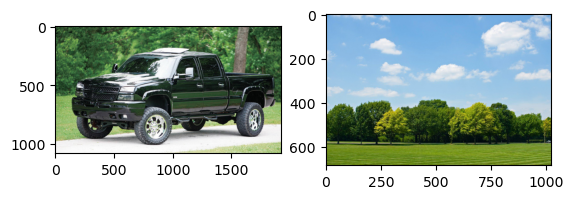

In [4]:
plt.subplot(1,2,1)
plt.imshow(load_img(im1_path))
plt.subplot(1,2,2)
plt.imshow(load_img(im2_path))
plt.show()

In [5]:
class Resnet50GradCAM(torch.nn.Module):
    def __init__(self) -> None:
        super(Resnet50GradCAM, self).__init__()
        
        self.resnet = models.resnet50(pretrained=True).eval()
        
        self.feature_extract = torch.nn.Sequential(*list(self.resnet.children())[:-1])#remove dense layers from resnet
        
        self.target_layer = self.resnet.layer4[-1]
        
        self.forward_hook = self.target_layer.register_forward_hook(self.activation_hook)
        self.backward_hook = self.target_layer.register_forward_hook(self.save_gradient)
        #self.backward_hook = self.target_layer.register_full_backward_hook(self.save_gradient) #<-- this is broken for now
        
        self.gradients = []
        self.activations = []
    
    def activation_hook(self,module,input,output):
        self.activations = output.cpu().detach()
    
    #FULL DISCLOSURE: this is 1-1 copied (except some deleted transforms) from pytorch-grad-cam https://github.com/jacobgil/pytorch-grad-cam/blob/master/pytorch_grad_cam/activations_and_gradients.py
    #Why? for some reason register_backward_hook() https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook
    #returns a weird gradient that breaks things. How? I don't really know, all I know is that this same code, using backward hooks marked the truck as being
    #the reason the pictures are similar, not the trees ¯\_(ツ)_/¯
    #
    #There is some serious tomfoolery going on...
    def save_gradient(self, module, input, output):
        if not hasattr(output, "requires_grad") or not output.requires_grad:
            # You can only register hooks on tensor requires grad.
            return

        # Gradients are computed in reverse order
        def _store_grad(grad):
            self.gradients = [grad.cpu().detach()] + self.gradients

        output.register_hook(_store_grad)
    
    #def gradient_hook(self,module, grad_input, grad_output):
    #    self.gradients = grad_output[0].cpu().detach() #grad_output is a tuple for some reason idk
        
    def forward(self,x:torch.Tensor):
        return self.feature_extract(x)[0,:,0,0]
    
    def get_gradients(self):
        return self.gradients[-1]
    
    def get_activations(self):
        return self.activations

In [6]:
model = Resnet50GradCAM().to(device)

/home/j-millet/anaconda3/envs/torch-cv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/j-millet/anaconda3/envs/torch-cv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
im1_tensor = load_image_into_resnet_tensor(im1_path,device=device)
im2_tensor = load_image_into_resnet_tensor(im2_path,device=device)

im1_tensor.shape, im2_tensor.shape

(torch.Size([1, 3, 224, 398]), torch.Size([1, 3, 224, 334]))

In [8]:
im2_features = model(im2_tensor) #<- compute features of other image, to compute similarity later
im2_features.shape

torch.Size([2048])

# Grad cam

### Gradients

In [9]:
im1_features = model(im1_tensor) #do forward pass

cos = torch.nn.functional.cosine_similarity(im1_features,im2_features,dim=0).to(device)

cos.backward() #do backward pass

In [10]:
grad = model.get_gradients() # <- collected gradients (7x13 for each of 2048 channels)
grad.shape

torch.Size([1, 2048, 7, 13])

In [11]:
grad_pooled = torch.mean(grad,dim=[0,2,3]) #<- global average pooling of gradients
grad_pooled

tensor([ 2.8969e-06,  1.1895e-05,  5.2125e-06,  ..., -8.9957e-07,
         5.5052e-06, -1.9450e-07])

### Activations

In [12]:
layer_activations = model.get_activations()
layer_activations.shape

torch.Size([1, 2048, 7, 13])

### Heatmap


In [13]:
# activations are weighed by pooled gradients
for i in range(2048):
    layer_activations[:,i,:,:] *= grad_pooled[i]

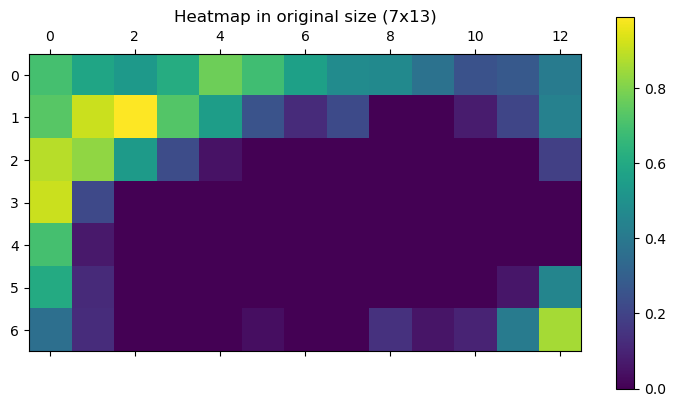

In [17]:
heatmap = torch.mean(layer_activations,dim=1).squeeze(0).cpu()
heatmap = np.maximum(heatmap,0) #apply relu to heatmap
heatmap = heatmap/(torch.max(heatmap) + 0.00000001) #normalize to 0-1

heatmap = heatmap.numpy()

plt.matshow(heatmap)
plt.title("Heatmap in original size (7x13)")
plt.colorbar()

### Resize heatmap to original image size

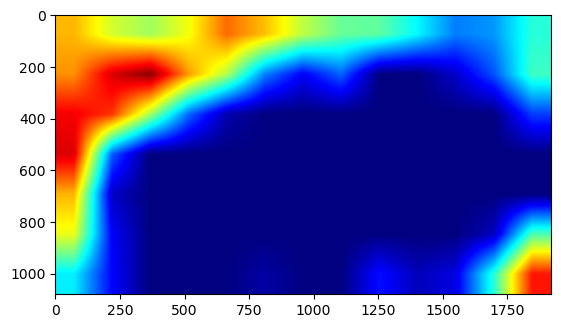

In [18]:
import cv2
img = cv2.imread(im1_path)
heatmap_cv = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap_cv = np.uint8(255 * heatmap_cv)
heatmap_cv = cv2.applyColorMap(heatmap_cv, cv2.COLORMAP_JET)
plt.imshow(heatmap_cv[...,::-1])

### Heatmap resized and superimposed

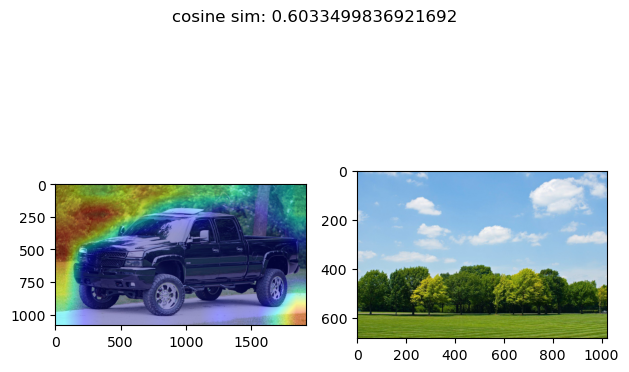

In [19]:
alpha = 0.4
plt.subplot(1,2,1)
plt.imshow((heatmap_cv *alpha + img*(1-alpha)).astype(np.uint8)[...,::-1])

plt.subplot(1,2,2)
plt.imshow(load_img(im2_path))

plt.suptitle(f"cosine sim: {np.round(cos.cpu().detach().numpy(),5)}")
plt.tight_layout()